In [705]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
%matplotlib inline

## Functions to extract features
1. Spatial features
2. Histogram features
3. HoG features
4. Combining features
5. Draw boxes
6. Color Transform

In [759]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
            
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return img

## Reading Data and Extracting features
Define various parameter for feature extraction here

In [771]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
    
# Read in cars and notcars
cars = glob.glob('./Data/vehicles/**/**/*.png')
notcars = glob.glob('./Data/non-vehicles/**/**/*.png')

print("Total Cars: ", len(cars), " | Total Non-Cars: ", len(notcars))
# cars = []
# notcars = []
# for image in images:
#     if 'notcar' in image:
#         notcars.append(image)
#     else:
#         cars.append(image)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
# sample_size = 8000
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()

t=time.time()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Time to extract features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

Total Cars:  8792  | Total Non-Cars:  8968
45.49 Time to extract features...


## Visualize Training Data
Car and Non-car Data is shown

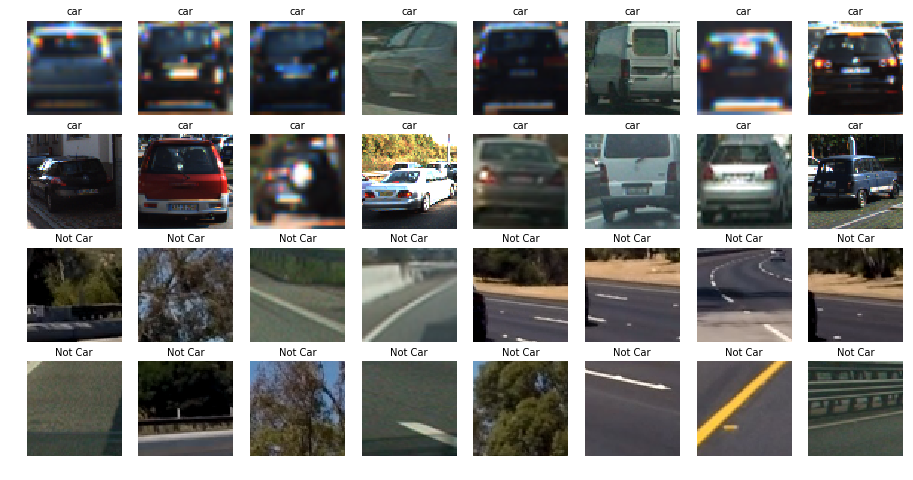

In [837]:
fig, axs = plt.subplots(4,8, figsize=(16, 8))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(16):
    img = cv2.imread(cars[np.random.randint(0,len(cars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(16,32):
    img = cv2.imread(notcars[np.random.randint(0,len(notcars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Not Car', fontsize=10)
    axs[i].imshow(img)
    
fig.savefig("car_noncar.png")

## Visualize Features

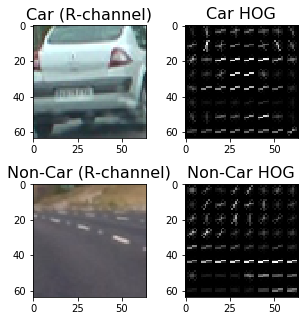

In [839]:
car = cv2.imread(cars[15])
_, car_dst = get_hog_features(car[:,:,0], 9, 8, 8, vis=True, feature_vec=True)

notcar = cv2.imread(notcars[15])
_, noncar_dst = get_hog_features(notcar[:,:,0], 9, 8, 8, vis=True, feature_vec=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(5,5))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car (R-channel)', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car (R-channel)', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

f.savefig("./output_images/hog_features.png")

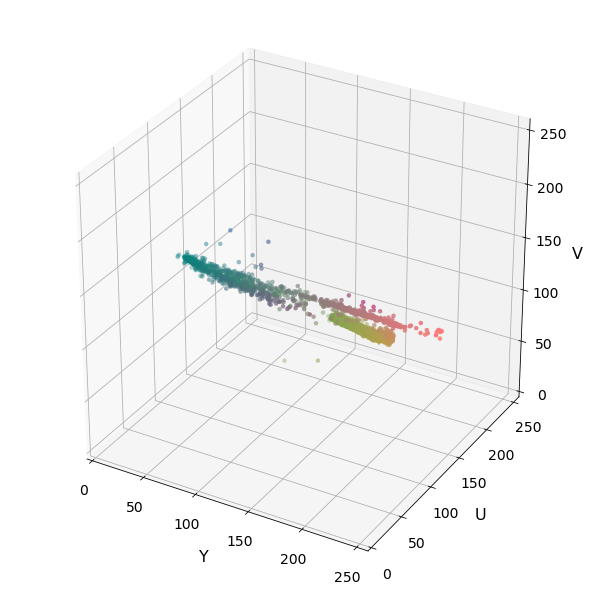

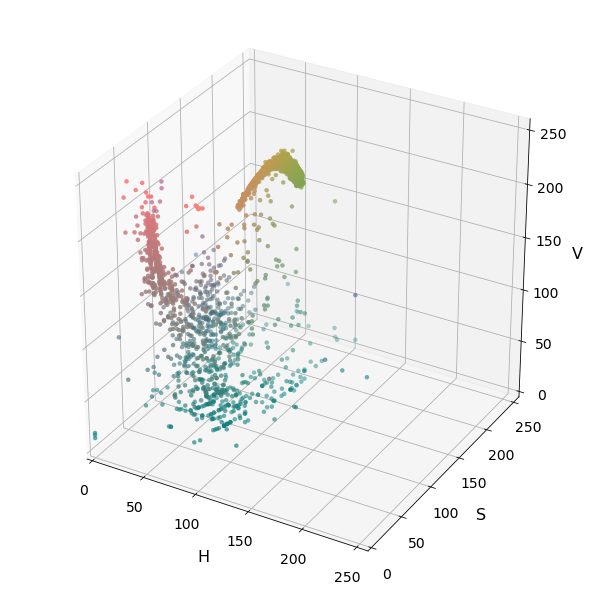

In [834]:
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

img = cv2.imread("./test_images/bbox-example-image.jpg")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2YUV)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb, axis_labels=list("YUV"))
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

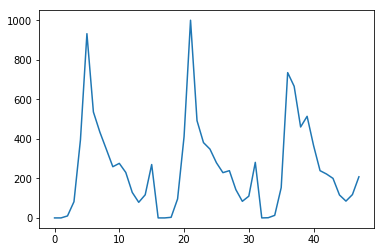

In [836]:
car = cv2.imread(cars[15])
cv2.imwrite("./output_images/sample_car.jpg", car)
hist = color_hist(car, nbins=hist_bins)


plt.plot(hist)
plt.savefig("./output_images/histogram.png")
plt.show()

## Training a SVM 
1. Split data into train and test.
2. Define SVM
3. Train model
3. Check accuracy of trained model on test data

In [752]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# parameters = {'kernel':('linear', 'rbf'), 'C':[2,3,4]}

# svc = SVC(kernel='rbf', C=3)
# svc = GridSearchCV(svr, parameters)

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
# svc.best_params_

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2004
2.73 Seconds to train SVC...
Test Accuracy of SVC =  0.9856
My SVC predicts:  [ 1.  1.  1.  0.  1.  1.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  1.  1.  1.  0.  1.]
0.00128 Seconds to predict 10 labels with SVC


## Sliding Window Function and feature extraction
1. Find HOG of scaled image
2. Combine Spatial, histogram and HoG features for each fixed window

In [820]:
# with open('svc_pickle.p', 'wb') as f:
#     pickle.dump([svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins], f)
# dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )    

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, show_all=True):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    box_list = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
#     plt.imshow(ctrans_tosearch)
#     plt.show()
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, 
                                                          hog_features)).reshape(1, -1))    
#             test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_all:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
  
    return box_list

## Handling False Positives
1. Add all box to generate heatmap
2. Apply threshold to heatmap
3. Draw the filtered boxes

In [821]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
box_list = boxlist1

# Read in image similar to one shown above 
image = mpimg.imread('./test_images/bbox-example-image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Test Images

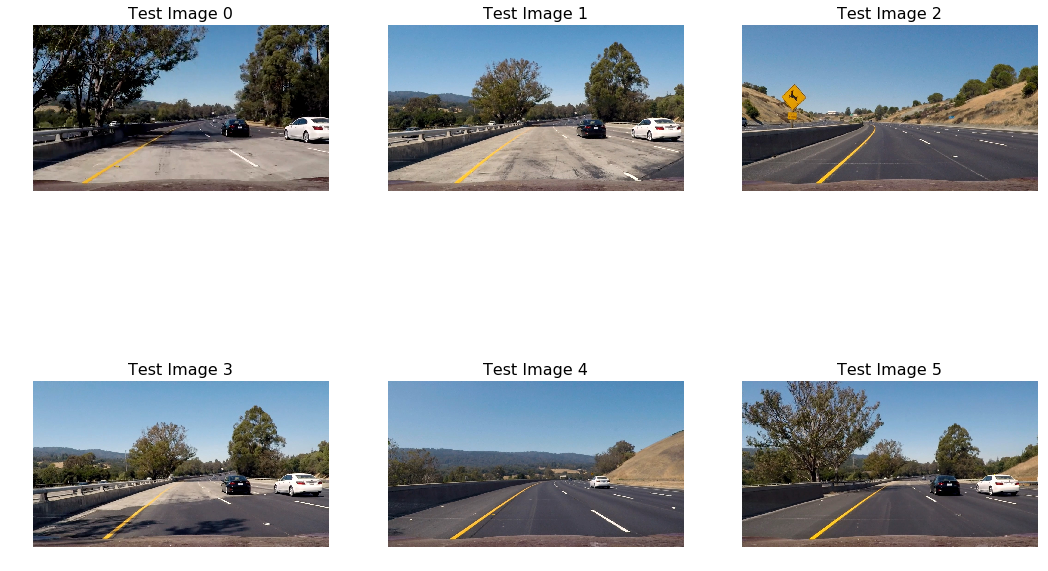

In [949]:
f, ax = plt.subplots(2, 3, figsize=(18,12))
fig.subplots_adjust(hspace = .2, wspace=.001)
ax = ax.ravel()

for i, im in enumerate(glob.glob("./test_images/test*")):
    image = mpimg.imread(im)
    ax[i].axis('off')
    ax[i].set_title('Test Image {}'.format(i), fontsize=16)
    ax[i].imshow(image)
f.savefig("./output_images/test_images.png")

## Evaluating the complete model on a test image

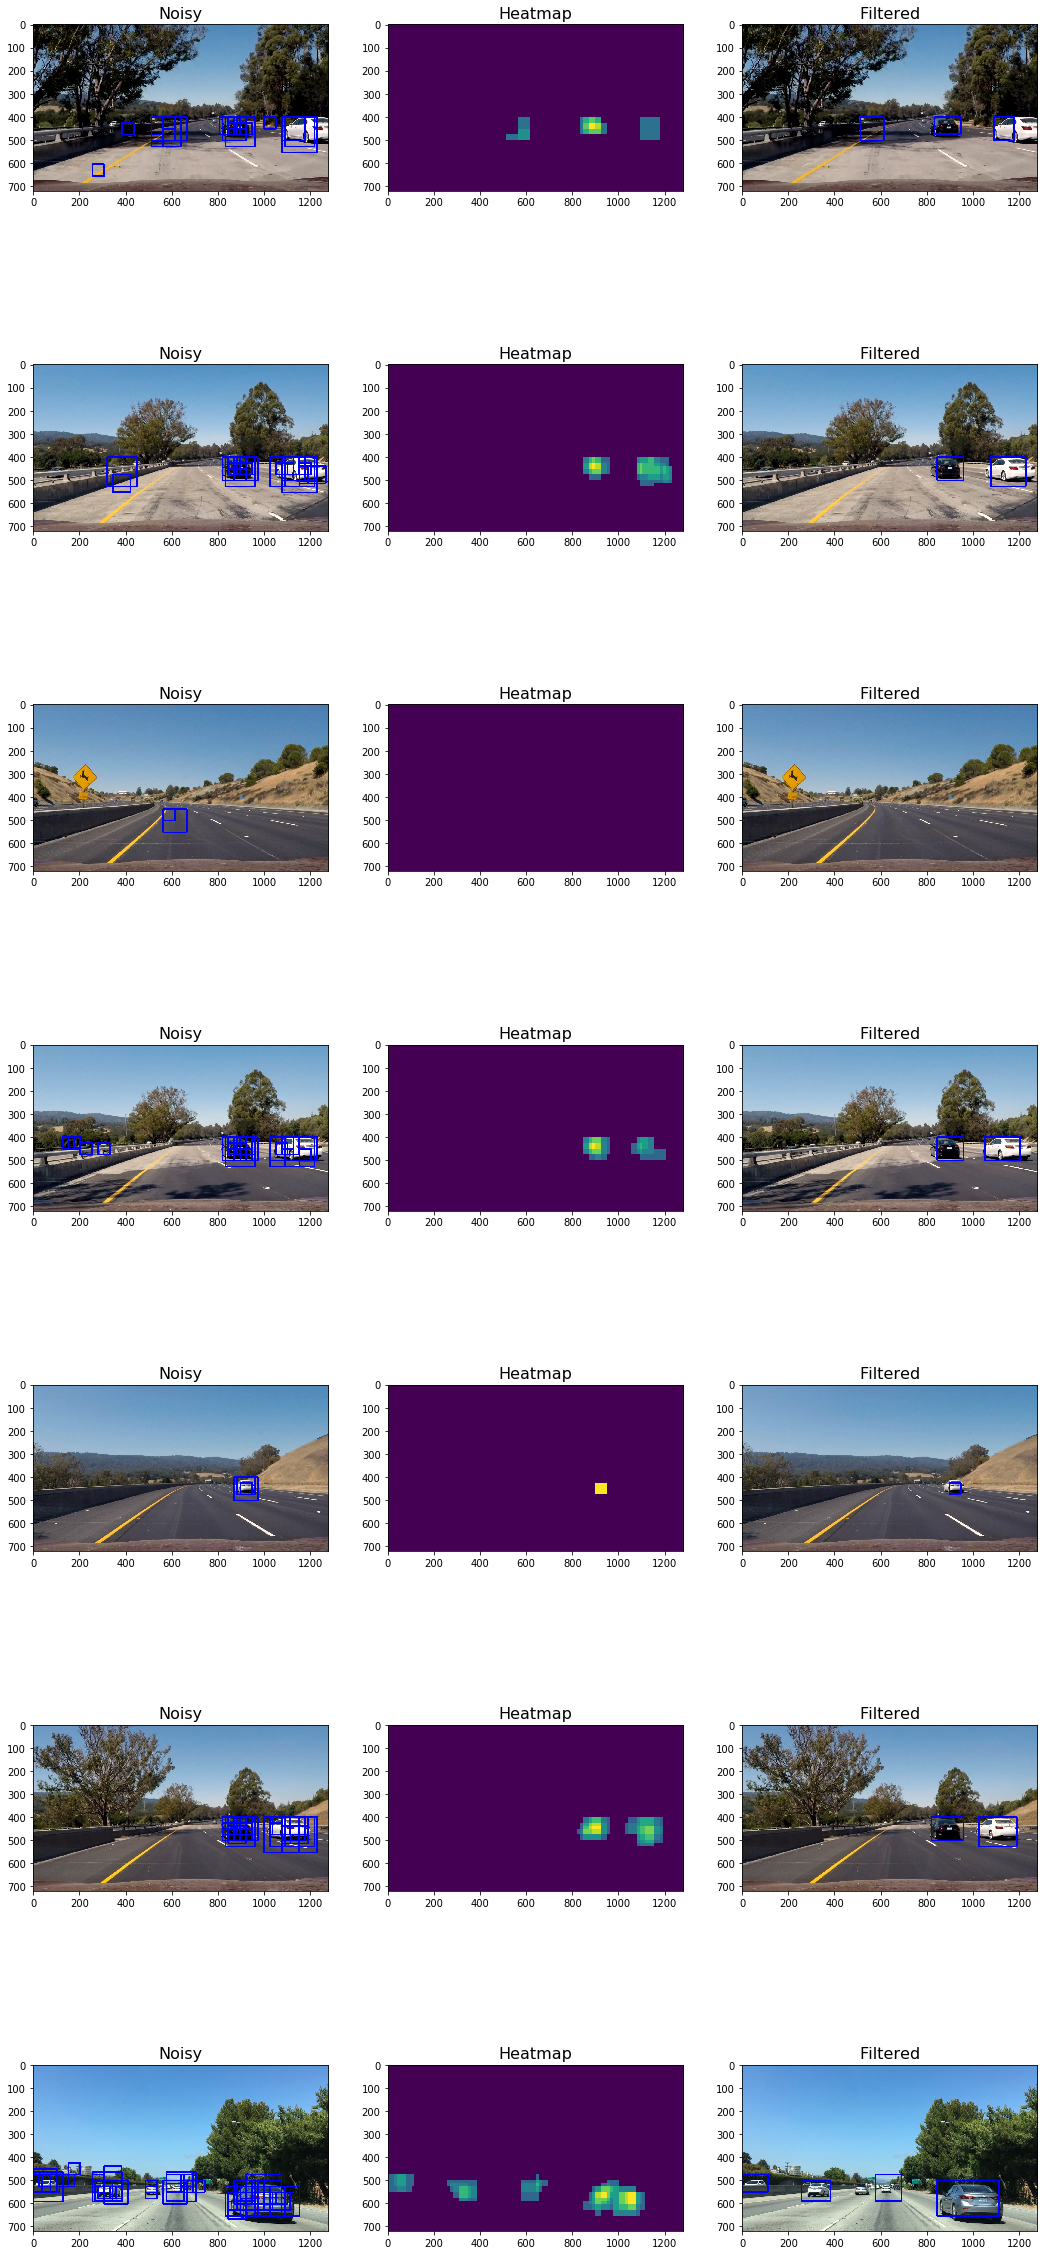

In [886]:
f, ax = plt.subplots(7, 3, figsize=(18,42))
fig.subplots_adjust(hspace = .2, wspace=.001)
ax = ax.ravel()

for i, im in enumerate(glob.glob("./test_images/*")):
    image = mpimg.imread(im)
    box_list = []
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    for scale in np.arange(0.8,2.5,0.4):
        ystart = 400
        ystop = 700
    #     scale = 1.5
        box_list += find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, hist_bins,False)

    out_img = draw_boxes(image, box_list)

    heat = add_heat(heat, box_list)
    heat = apply_threshold(heat,2)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    ax[3*i].imshow(out_img)
    ax[3*i].set_title('Noisy', fontsize=16)
    ax[3*i+1].imshow(heat)
    ax[3*i+1].set_title('Heatmap', fontsize=16)
    ax[3*i+2].imshow(draw_img)
    ax[3*i+2].set_title('Filtered', fontsize=16)

f.savefig("./output_images/pipeline.png")
    
# plt.imshow(out_img)
# plt.savefig("./output_images/unclean.png")
# plt.show()
# plt.imshow(heat)
# plt.savefig("./output_images/heat.png")
# plt.show()
# plt.imshow(draw_img)
# plt.savefig("./output_images/clean.png")
# plt.show()

## Smooth Detection using few previously detected boxes

In [763]:
class smooth_detection():
    def __init__(self):
        self.prev_rects = [] 
        
    def combined_box(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

## Defining the complete process
Images from video are fed to this function

In [973]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    rectangles = []

    colorspace = 'YUV'
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL'
    

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False))
    
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False))

    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False))

    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False))

    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False))

    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False))

    ystart = 400
    ystop = 596
    scale = 3.0
    rectangles.append(find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False))

    ystart = 464
    ystop = 660
    scale = 3.0
    rectangles.append(find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False))

 
    rectangles = [item for sublist in rectangles for item in sublist] 

    if len(rectangles) > 0:
        det.combined_box(rectangles)
    
    heatmap = np.zeros_like(image[:,:,0])
    for rect_set in det.prev_rects:
        heatmap = add_heat(heatmap, rect_set)
    
    a2 = cv2.resize(heatmap, (0,0), fx=0.25, fy=0.25)
    a2 = np.dstack((a2, a2, a2))*255
    
    heatmap_img = apply_threshold(heatmap, 3 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    cv2.putText(draw_img,'Noisy Heatmap',(100,35),1,1.0,[255,255,255],1,cv2.LINE_AA)
    cv2.putText(draw_img,'Label Heatmap',(1045,35),1,1.0,[255,255,255],1,cv2.LINE_AA)
    
    a1 = np.copy(draw_img)
    a3 = cv2.resize(heatmap_img, (0,0), fx=0.25, fy=0.25)
    a3 = np.dstack((a3, a3, a3))*255
    
    a1[50:a2.shape[0]+50,:a2.shape[1],:] = a2
    a1[50:a3.shape[0]+50,3*a3.shape[1]:4*a3.shape[1],:] = a3
    
    return a1

## Vehicle Detection in Videos

In [974]:
det = smooth_detection()

white_output = './output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./output.mp4
[MoviePy] Writing video ./output.mp4












  0%|          | 0/1261 [00:00<?, ?it/s]









  0%|          | 1/1261 [00:00<05:51,  3.58it/s]









  0%|          | 2/1261 [00:00<05:53,  3.56it/s]









  0%|          | 3/1261 [00:00<05:51,  3.57it/s]









  0%|          | 4/1261 [00:01<05:49,  3.59it/s]









  0%|          | 5/1261 [00:01<05:51,  3.58it/s]









  0%|          | 6/1261 [00:01<05:49,  3.59it/s]









  1%|          | 7/1261 [00:01<05:48,  3.60it/s]









  1%|          | 8/1261 [00:02<05:49,  3.59it/s]









  1%|          | 9/1261 [00:02<05:48,  3.60it/s]









  1%|          | 10/1261 [00:02<05:56,  3.51it/s]









  1%|          | 11/1261 [00:03<05:58,  3.49it/s]









  1%|          | 12/1261 [00:03<06:05,  3.42it/s]









  1%|          | 13/1261 [00:03<06:05,  3.41it/s]









  1%|          | 14/1261 [00:03<05:59,  3.47it/s]









  1%|          | 15/1261 [00:04<05:55,  3.51it/s]









  1%|▏         | 16/1261 [00:04<05:51,  3.54it/s]









  1%|

  7%|▋         | 92/1261 [00:26<05:23,  3.61it/s]









  7%|▋         | 93/1261 [00:26<05:23,  3.61it/s]









  7%|▋         | 94/1261 [00:27<05:23,  3.61it/s]









  8%|▊         | 95/1261 [00:27<05:23,  3.61it/s]









  8%|▊         | 96/1261 [00:27<05:22,  3.62it/s]









  8%|▊         | 97/1261 [00:27<05:21,  3.61it/s]









  8%|▊         | 98/1261 [00:28<05:22,  3.61it/s]









  8%|▊         | 99/1261 [00:28<05:21,  3.61it/s]









  8%|▊         | 100/1261 [00:28<05:21,  3.61it/s]









  8%|▊         | 101/1261 [00:29<05:22,  3.60it/s]









  8%|▊         | 102/1261 [00:29<05:21,  3.60it/s]









  8%|▊         | 103/1261 [00:29<05:22,  3.59it/s]









  8%|▊         | 104/1261 [00:29<05:21,  3.60it/s]









  8%|▊         | 105/1261 [00:30<05:20,  3.60it/s]









  8%|▊         | 106/1261 [00:30<05:21,  3.60it/s]









  8%|▊         | 107/1261 [00:30<05:20,  3.60it/s]









  9%|▊         | 108/1261 [00:31<05:30,  3.49it/

 15%|█▍        | 183/1261 [00:53<05:07,  3.51it/s]









 15%|█▍        | 184/1261 [00:53<05:05,  3.53it/s]









 15%|█▍        | 185/1261 [00:53<05:03,  3.54it/s]









 15%|█▍        | 186/1261 [00:53<05:03,  3.54it/s]









 15%|█▍        | 187/1261 [00:54<05:02,  3.55it/s]









 15%|█▍        | 188/1261 [00:54<05:03,  3.54it/s]









 15%|█▍        | 189/1261 [00:54<05:01,  3.55it/s]









 15%|█▌        | 190/1261 [00:55<05:00,  3.56it/s]









 15%|█▌        | 191/1261 [00:55<05:00,  3.56it/s]









 15%|█▌        | 192/1261 [00:55<05:01,  3.55it/s]









 15%|█▌        | 193/1261 [00:55<05:01,  3.54it/s]









 15%|█▌        | 194/1261 [00:56<05:02,  3.53it/s]









 15%|█▌        | 195/1261 [00:56<05:02,  3.52it/s]









 16%|█▌        | 196/1261 [00:56<05:03,  3.51it/s]









 16%|█▌        | 197/1261 [00:57<05:04,  3.49it/s]









 16%|█▌        | 198/1261 [00:57<05:03,  3.50it/s]









 16%|█▌        | 199/1261 [00:57<05:04, 

 22%|██▏       | 274/1261 [01:19<04:37,  3.56it/s]









 22%|██▏       | 275/1261 [01:19<04:37,  3.55it/s]









 22%|██▏       | 276/1261 [01:19<04:37,  3.55it/s]









 22%|██▏       | 277/1261 [01:19<04:36,  3.56it/s]









 22%|██▏       | 278/1261 [01:20<04:35,  3.57it/s]









 22%|██▏       | 279/1261 [01:20<04:35,  3.57it/s]









 22%|██▏       | 280/1261 [01:20<04:34,  3.58it/s]









 22%|██▏       | 281/1261 [01:21<04:37,  3.53it/s]









 22%|██▏       | 282/1261 [01:21<04:37,  3.53it/s]









 22%|██▏       | 283/1261 [01:21<04:41,  3.47it/s]









 23%|██▎       | 284/1261 [01:21<04:39,  3.49it/s]









 23%|██▎       | 285/1261 [01:22<04:41,  3.47it/s]









 23%|██▎       | 286/1261 [01:22<04:39,  3.49it/s]









 23%|██▎       | 287/1261 [01:22<04:38,  3.50it/s]









 23%|██▎       | 288/1261 [01:23<04:36,  3.52it/s]









 23%|██▎       | 289/1261 [01:23<04:34,  3.54it/s]









 23%|██▎       | 290/1261 [01:23<04:34, 

 29%|██▉       | 365/1261 [01:44<04:12,  3.55it/s]









 29%|██▉       | 366/1261 [01:45<04:14,  3.52it/s]









 29%|██▉       | 367/1261 [01:45<04:14,  3.52it/s]









 29%|██▉       | 368/1261 [01:45<04:12,  3.53it/s]









 29%|██▉       | 369/1261 [01:45<04:12,  3.54it/s]









 29%|██▉       | 370/1261 [01:46<04:11,  3.54it/s]









 29%|██▉       | 371/1261 [01:46<04:11,  3.54it/s]









 30%|██▉       | 372/1261 [01:46<04:11,  3.53it/s]









 30%|██▉       | 373/1261 [01:47<04:11,  3.52it/s]









 30%|██▉       | 374/1261 [01:47<04:12,  3.52it/s]









 30%|██▉       | 375/1261 [01:47<04:11,  3.53it/s]









 30%|██▉       | 376/1261 [01:47<04:10,  3.53it/s]









 30%|██▉       | 377/1261 [01:48<04:13,  3.49it/s]









 30%|██▉       | 378/1261 [01:48<04:12,  3.50it/s]









 30%|███       | 379/1261 [01:48<04:10,  3.52it/s]









 30%|███       | 380/1261 [01:49<04:09,  3.53it/s]









 30%|███       | 381/1261 [01:49<04:08, 

 36%|███▌      | 456/1261 [02:10<03:50,  3.50it/s]









 36%|███▌      | 457/1261 [02:10<03:48,  3.52it/s]









 36%|███▋      | 458/1261 [02:11<03:47,  3.53it/s]









 36%|███▋      | 459/1261 [02:11<03:46,  3.55it/s]









 36%|███▋      | 460/1261 [02:11<03:44,  3.57it/s]









 37%|███▋      | 461/1261 [02:11<03:44,  3.57it/s]









 37%|███▋      | 462/1261 [02:12<03:43,  3.58it/s]









 37%|███▋      | 463/1261 [02:12<03:42,  3.58it/s]









 37%|███▋      | 464/1261 [02:12<03:42,  3.58it/s]









 37%|███▋      | 465/1261 [02:13<03:41,  3.59it/s]









 37%|███▋      | 466/1261 [02:13<03:41,  3.58it/s]









 37%|███▋      | 467/1261 [02:13<03:42,  3.57it/s]









 37%|███▋      | 468/1261 [02:13<03:42,  3.57it/s]









 37%|███▋      | 469/1261 [02:14<03:42,  3.57it/s]









 37%|███▋      | 470/1261 [02:14<03:43,  3.54it/s]









 37%|███▋      | 471/1261 [02:14<03:46,  3.49it/s]









 37%|███▋      | 472/1261 [02:15<03:46, 

 43%|████▎     | 547/1261 [02:36<03:21,  3.55it/s]









 43%|████▎     | 548/1261 [02:36<03:19,  3.57it/s]









 44%|████▎     | 549/1261 [02:36<03:19,  3.57it/s]









 44%|████▎     | 550/1261 [02:37<03:19,  3.57it/s]









 44%|████▎     | 551/1261 [02:37<03:18,  3.58it/s]









 44%|████▍     | 552/1261 [02:37<03:20,  3.53it/s]









 44%|████▍     | 553/1261 [02:37<03:23,  3.47it/s]









 44%|████▍     | 554/1261 [02:38<03:24,  3.46it/s]









 44%|████▍     | 555/1261 [02:38<03:23,  3.46it/s]









 44%|████▍     | 556/1261 [02:38<03:22,  3.49it/s]









 44%|████▍     | 557/1261 [02:39<03:22,  3.48it/s]









 44%|████▍     | 558/1261 [02:39<03:21,  3.49it/s]









 44%|████▍     | 559/1261 [02:39<03:20,  3.51it/s]









 44%|████▍     | 560/1261 [02:39<03:20,  3.50it/s]









 44%|████▍     | 561/1261 [02:40<03:19,  3.51it/s]









 45%|████▍     | 562/1261 [02:40<03:18,  3.52it/s]









 45%|████▍     | 563/1261 [02:40<03:20, 

 51%|█████     | 638/1261 [03:01<02:59,  3.47it/s]









 51%|█████     | 639/1261 [03:02<02:56,  3.52it/s]









 51%|█████     | 640/1261 [03:02<02:56,  3.53it/s]









 51%|█████     | 641/1261 [03:02<02:54,  3.55it/s]









 51%|█████     | 642/1261 [03:03<02:53,  3.57it/s]









 51%|█████     | 643/1261 [03:03<02:52,  3.58it/s]









 51%|█████     | 644/1261 [03:03<02:52,  3.58it/s]









 51%|█████     | 645/1261 [03:03<02:51,  3.60it/s]









 51%|█████     | 646/1261 [03:04<02:51,  3.60it/s]









 51%|█████▏    | 647/1261 [03:04<02:50,  3.60it/s]









 51%|█████▏    | 648/1261 [03:04<02:50,  3.61it/s]









 51%|█████▏    | 649/1261 [03:05<02:49,  3.60it/s]









 52%|█████▏    | 650/1261 [03:05<02:49,  3.60it/s]









 52%|█████▏    | 651/1261 [03:05<02:49,  3.61it/s]









 52%|█████▏    | 652/1261 [03:05<02:49,  3.60it/s]









 52%|█████▏    | 653/1261 [03:06<02:48,  3.60it/s]









 52%|█████▏    | 654/1261 [03:06<02:48, 

 58%|█████▊    | 729/1261 [03:27<02:28,  3.57it/s]









 58%|█████▊    | 730/1261 [03:27<02:28,  3.57it/s]









 58%|█████▊    | 731/1261 [03:28<02:28,  3.57it/s]









 58%|█████▊    | 732/1261 [03:28<02:28,  3.56it/s]









 58%|█████▊    | 733/1261 [03:28<02:29,  3.54it/s]









 58%|█████▊    | 734/1261 [03:28<02:29,  3.53it/s]









 58%|█████▊    | 735/1261 [03:29<02:29,  3.52it/s]









 58%|█████▊    | 736/1261 [03:29<02:28,  3.53it/s]









 58%|█████▊    | 737/1261 [03:29<02:28,  3.53it/s]









 59%|█████▊    | 738/1261 [03:30<02:28,  3.53it/s]









 59%|█████▊    | 739/1261 [03:30<02:28,  3.52it/s]









 59%|█████▊    | 740/1261 [03:30<02:29,  3.50it/s]









 59%|█████▉    | 741/1261 [03:30<02:29,  3.47it/s]









 59%|█████▉    | 742/1261 [03:31<02:28,  3.48it/s]









 59%|█████▉    | 743/1261 [03:31<02:28,  3.49it/s]









 59%|█████▉    | 744/1261 [03:31<02:27,  3.51it/s]









 59%|█████▉    | 745/1261 [03:32<02:26, 

 65%|██████▌   | 820/1261 [03:53<02:05,  3.51it/s]









 65%|██████▌   | 821/1261 [03:53<02:05,  3.52it/s]









 65%|██████▌   | 822/1261 [03:53<02:04,  3.53it/s]









 65%|██████▌   | 823/1261 [03:54<02:04,  3.53it/s]









 65%|██████▌   | 824/1261 [03:54<02:03,  3.55it/s]









 65%|██████▌   | 825/1261 [03:54<02:02,  3.57it/s]









 66%|██████▌   | 826/1261 [03:55<02:02,  3.55it/s]









 66%|██████▌   | 827/1261 [03:55<02:02,  3.54it/s]









 66%|██████▌   | 828/1261 [03:55<02:02,  3.54it/s]









 66%|██████▌   | 829/1261 [03:55<02:02,  3.53it/s]









 66%|██████▌   | 830/1261 [03:56<02:02,  3.53it/s]









 66%|██████▌   | 831/1261 [03:56<02:01,  3.53it/s]









 66%|██████▌   | 832/1261 [03:56<02:01,  3.53it/s]









 66%|██████▌   | 833/1261 [03:57<02:01,  3.52it/s]









 66%|██████▌   | 834/1261 [03:57<02:06,  3.37it/s]









 66%|██████▌   | 835/1261 [03:57<02:04,  3.42it/s]









 66%|██████▋   | 836/1261 [03:57<02:04, 

 72%|███████▏  | 911/1261 [04:19<01:40,  3.50it/s]









 72%|███████▏  | 912/1261 [04:19<01:39,  3.52it/s]









 72%|███████▏  | 913/1261 [04:19<01:38,  3.54it/s]









 72%|███████▏  | 914/1261 [04:20<01:37,  3.55it/s]









 73%|███████▎  | 915/1261 [04:20<01:37,  3.54it/s]









 73%|███████▎  | 916/1261 [04:20<01:37,  3.54it/s]









 73%|███████▎  | 917/1261 [04:20<01:37,  3.52it/s]









 73%|███████▎  | 918/1261 [04:21<01:37,  3.54it/s]









 73%|███████▎  | 919/1261 [04:21<01:36,  3.54it/s]









 73%|███████▎  | 920/1261 [04:21<01:35,  3.55it/s]









 73%|███████▎  | 921/1261 [04:22<01:35,  3.56it/s]









 73%|███████▎  | 922/1261 [04:22<01:35,  3.56it/s]









 73%|███████▎  | 923/1261 [04:22<01:34,  3.57it/s]









 73%|███████▎  | 924/1261 [04:22<01:34,  3.57it/s]









 73%|███████▎  | 925/1261 [04:23<01:34,  3.56it/s]









 73%|███████▎  | 926/1261 [04:23<01:34,  3.56it/s]









 74%|███████▎  | 927/1261 [04:23<01:33, 

 79%|███████▉  | 1002/1261 [04:45<01:15,  3.45it/s]









 80%|███████▉  | 1003/1261 [04:45<01:14,  3.46it/s]









 80%|███████▉  | 1004/1261 [04:45<01:14,  3.47it/s]









 80%|███████▉  | 1005/1261 [04:45<01:13,  3.47it/s]









 80%|███████▉  | 1006/1261 [04:46<01:13,  3.45it/s]









 80%|███████▉  | 1007/1261 [04:46<01:13,  3.44it/s]









 80%|███████▉  | 1008/1261 [04:46<01:13,  3.45it/s]









 80%|████████  | 1009/1261 [04:47<01:12,  3.47it/s]









 80%|████████  | 1010/1261 [04:47<01:12,  3.46it/s]









 80%|████████  | 1011/1261 [04:47<01:12,  3.47it/s]









 80%|████████  | 1012/1261 [04:47<01:11,  3.48it/s]









 80%|████████  | 1013/1261 [04:48<01:11,  3.47it/s]









 80%|████████  | 1014/1261 [04:48<01:11,  3.47it/s]









 80%|████████  | 1015/1261 [04:48<01:11,  3.46it/s]









 81%|████████  | 1016/1261 [04:49<01:10,  3.47it/s]









 81%|████████  | 1017/1261 [04:49<01:10,  3.47it/s]









 81%|████████  | 1018/12

 87%|████████▋ | 1092/1261 [05:10<00:47,  3.53it/s]









 87%|████████▋ | 1093/1261 [05:10<00:47,  3.52it/s]









 87%|████████▋ | 1094/1261 [05:11<00:47,  3.52it/s]









 87%|████████▋ | 1095/1261 [05:11<00:47,  3.52it/s]









 87%|████████▋ | 1096/1261 [05:11<00:47,  3.49it/s]









 87%|████████▋ | 1097/1261 [05:12<00:46,  3.50it/s]









 87%|████████▋ | 1098/1261 [05:12<00:46,  3.50it/s]









 87%|████████▋ | 1099/1261 [05:12<00:46,  3.51it/s]









 87%|████████▋ | 1100/1261 [05:12<00:45,  3.51it/s]









 87%|████████▋ | 1101/1261 [05:13<00:45,  3.53it/s]









 87%|████████▋ | 1102/1261 [05:13<00:44,  3.53it/s]









 87%|████████▋ | 1103/1261 [05:13<00:44,  3.52it/s]









 88%|████████▊ | 1104/1261 [05:14<00:44,  3.50it/s]









 88%|████████▊ | 1105/1261 [05:14<00:44,  3.51it/s]









 88%|████████▊ | 1106/1261 [05:14<00:44,  3.51it/s]









 88%|████████▊ | 1107/1261 [05:14<00:43,  3.52it/s]









 88%|████████▊ | 1108/12

 94%|█████████▎| 1182/1261 [05:36<00:22,  3.53it/s]









 94%|█████████▍| 1183/1261 [05:36<00:22,  3.53it/s]









 94%|█████████▍| 1184/1261 [05:36<00:21,  3.55it/s]









 94%|█████████▍| 1185/1261 [05:36<00:21,  3.56it/s]









 94%|█████████▍| 1186/1261 [05:37<00:20,  3.57it/s]









 94%|█████████▍| 1187/1261 [05:37<00:20,  3.58it/s]









 94%|█████████▍| 1188/1261 [05:37<00:20,  3.59it/s]









 94%|█████████▍| 1189/1261 [05:38<00:20,  3.52it/s]









 94%|█████████▍| 1190/1261 [05:38<00:20,  3.53it/s]









 94%|█████████▍| 1191/1261 [05:38<00:19,  3.55it/s]









 95%|█████████▍| 1192/1261 [05:38<00:19,  3.57it/s]









 95%|█████████▍| 1193/1261 [05:39<00:18,  3.58it/s]









 95%|█████████▍| 1194/1261 [05:39<00:18,  3.57it/s]









 95%|█████████▍| 1195/1261 [05:39<00:18,  3.56it/s]









 95%|█████████▍| 1196/1261 [05:40<00:18,  3.55it/s]









 95%|█████████▍| 1197/1261 [05:40<00:18,  3.55it/s]









 95%|█████████▌| 1198/12

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output.mp4 

CPU times: user 6min, sys: 2.35 s, total: 6min 2s
Wall time: 5min 59s


In [975]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))